In [1]:
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo
%matplotlib nbagg
from astropy.table import Column

Neural networks not available in this version of scikit-learn. Neural networks are available from development version 0.18.


## SN numbers with classification code
SN001695   - 33

2457 - 33

2542 - 1

5399 - 2

13481 - 2

13866 - 1 

16742 - 21

17270 - 32

27266 -32

64968 - 23

149147 -21

In [2]:
dataset='spcc'

In [3]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
outdir=os.path.join('output_%s_no_z' %dataset,'')
out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

In [4]:
#Data root
rt=os.path.join('SPCC_SUBSET','')

In [5]:
dat=sndata.Dataset(rt)

subset is a string
Reading data...
11 objects read into memory.


In [6]:
#For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3)
types=dat.get_types()
types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3

In [7]:
read_from_file=False #True #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'%s_all' %dataset)

In [8]:
dat.object_names[0]

'DES_SN001695.DAT'

In [9]:
test_table = dat.data['DES_SN001695.DAT'] #get_lightcurve

In [10]:
type_II = []
for i in range(len(dat.data['DES_SN001695.DAT']['flux'])):
    type_II.append(np.random.normal(dat.data['DES_SN001695.DAT']['flux'][i], dat.data['DES_SN001695.DAT']['flux_error'][i], 5))

In [11]:
type_Ia = []
for i in range(len(dat.data['DES_SN002542.DAT']['flux'])):
    type_Ia.append(np.random.normal(dat.data['DES_SN002542.DAT']['flux'][i], dat.data['DES_SN002542.DAT']['flux_error'][i], 5))

In [12]:
type_Ibc = []
for i in range(len(dat.data['DES_SN005399.DAT']['flux'])):
    type_Ibc.append(np.random.normal(dat.data['DES_SN005399.DAT']['flux'][i], dat.data['DES_SN005399.DAT']['flux_error'][i], 5))

In [13]:
type_Ia = np.array(type_Ia)
type_Ibc = np.array(type_Ibc)
type_II = np.array(type_II)

In [14]:
test_table.replace_column('flux', type_II[:,0])

In [15]:
#test_table.write('testing.dat',format = 'ascii')

In [16]:
#dat.data['DES_SN001695.DAT']


In [17]:
isinstance(dat.object_names, np.ndarray)

True

In [18]:
test_table_II = dat.data['DES_SN001695.DAT']
test_table_Ia = dat.data['DES_SN002542.DAT']
test_table_Ibc = dat.data['DES_SN005399.DAT']

objs=[]
new_data={}

for i in range(5):
    
    test_table_Ia.replace_column('flux', type_Ia[:,i])
    #new_light_curve_Ia= test_table_Ia
    
    #new_light_curve_Ibc= 
    test_table_Ibc.replace_column('flux', type_Ibc[:,i])
    #new_light_curve_II= 
    test_table_II.replace_column('flux', type_II[:,i])
    
    #objs.append((str)(i))
    new_data[(str)(i)]=test_table_Ia.copy()  #new_light_curve_Ia
    new_data[(str)(i+5)]=test_table_II.copy()#new_light_curve_II
    new_data[(str)(i+10)]=test_table_Ibc.copy()#new_light_curve_Ibc

#new_data = Counter(new_data_Ia) + Counter(new_data_II) + Counter(new_data_Ibc)

for i in range(15):    
    objs.append((str)(i))
    
dat.object_names=np.asarray(objs)
dat.data=new_data

<IPython.core.display.Javascript object>


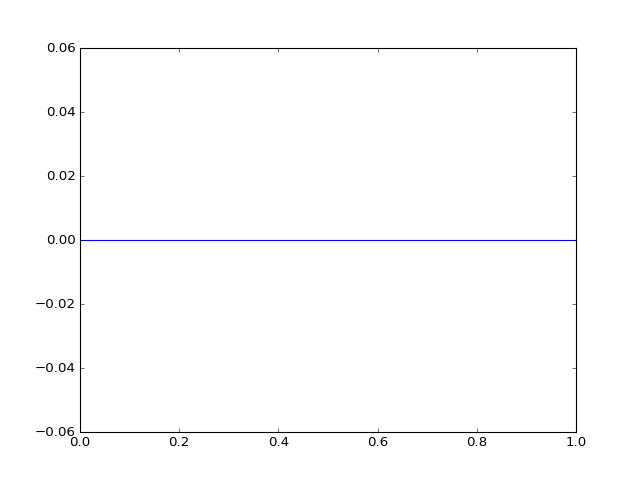

In [19]:
dat.plot_all()
#dat.data[dat.object_names[0]]

In [20]:
waveFeats=snfeatures.WaveletFeatures()

In [21]:
%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
else:
    wave_features=waveFeats.extract_features(dat,nprocesses=6,output_root=out_int,save_output='all')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean

Performing Gaussian process regression
Time taken for Gaussian process regression 38.7793679237
<type 'numpy.ndarray'>
Performing wavelet decomposition
Time for wavelet decomposition 1.63216590881
Running PCA...
Time for PCA 1.04918503761


In [22]:
np.sort(dat.object_names)

array(['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6',
       '7', '8', '9'], 
      dtype='|S2')

In [23]:
dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)

Fitting supernova models...
Models fitted.


<IPython.core.display.Javascript object>


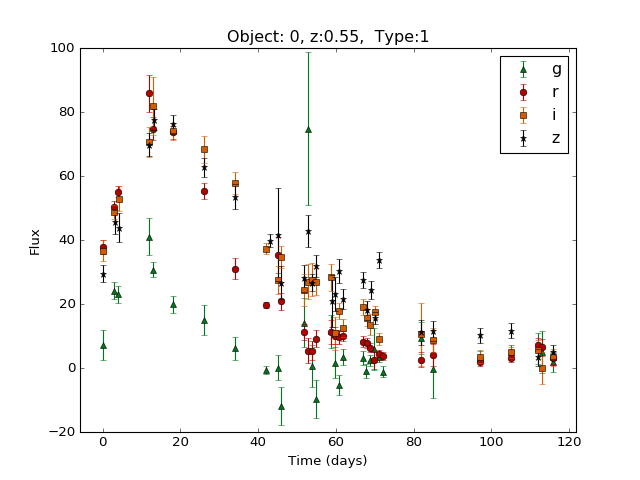

In [32]:
dat.plot_all()

In [25]:
wave_features

Object,C0,C1
str2,float64,float64
0,-764.523855673,-119.653027565
1,-809.861144819,-30.5744575482
2,-762.642382713,-68.3198518204
3,-730.451281606,-155.817412771
4,-764.198651717,-112.696002762
5,571.722816734,256.778057754
6,599.975193183,257.801063036
7,577.566160051,238.700187059
8,578.863388395,269.329349231


In [26]:
types

Object,Type
str16,int64
DES_SN001695.DAT,2
DES_SN002457.DAT,3
DES_SN002542.DAT,1
DES_SN005399.DAT,2
DES_SN013481.DAT,2
DES_SN013866.DAT,1
DES_SN016742.DAT,2
DES_SN017270.DAT,3
DES_SN027266.DAT,3


In [27]:
join(wave_features, types)

Object,C0,C1,Type
str16,float64,float64,int64


<IPython.core.display.Javascript object>


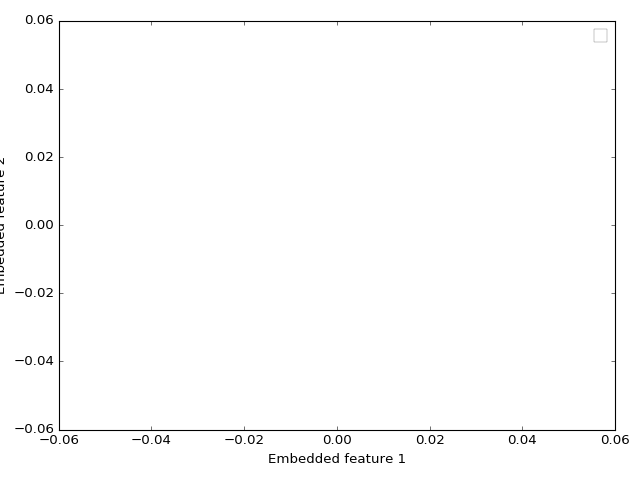

In [28]:
plt.figure()
tsne_plot.plot(wave_features,join(wave_features,types)['Type'])

In [29]:
#This is a Features object, not yet the extracted features
#We need to register the LSST bands with sncosmo (which is why lsst_bands=True)
salt2Feats=snfeatures.TemplateFeatures(sampler='leastsq') 

#This performs the actual feature extraction. All feature extraction methods are parallelised with multiprocessing, 
#just set nprocesses>1 for parallelisation.
if read_from_file:
    salt2_features=Table.read('%s_templates.dat' %run_name, format='ascii')
    blah=salt2_features['Object'].astype(str)
    salt2_features.replace_column('Object', blah)
else:
    salt2_features=salt2Feats.extract_features(dat,use_redshift=True,nprocesses=6,chain_directory=out_int)
    salt2_features.write('%s_templates.dat' %run_name, format='ascii')
    


Fitting templates using leastsq ...
15 objects fitted
Time taken is 9.37 seconds


In [30]:
#This code takes the fitted parameters and generates the model light curve for plotting purposes.
dat.set_model(salt2Feats.fit_sn,salt2_features)

Fitting supernova models...
No feature set found for DES_SN002542.DAT
No feature set found for DES_SN002542.DAT
No feature set found for DES_SN002542.DAT
No feature set found for DES_SN002542.DAT
No feature set found for DES_SN002542.DAT
No feature set found for DES_SN001695.DAT
No feature set found for DES_SN001695.DAT
No feature set found for DES_SN001695.DAT
No feature set found for DES_SN001695.DAT
No feature set found for DES_SN001695.DAT
No feature set found for DES_SN005399.DAT
No feature set found for DES_SN005399.DAT
No feature set found for DES_SN005399.DAT
No feature set found for DES_SN005399.DAT
No feature set found for DES_SN005399.DAT
Models fitted.


<IPython.core.display.Javascript object>


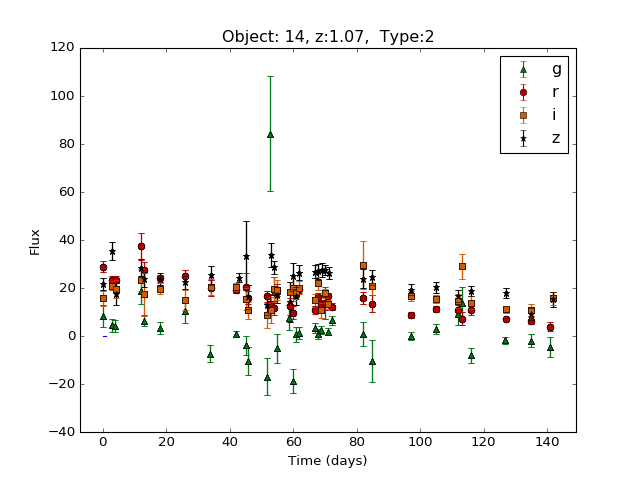

In [31]:
dat.plot_all()